#ИИС - Лаб 2 - 151211

Инсталирање на потребните пакети

In [ ]:
!pip install torch
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

Инпортирање на потребните библиотеки

In [26]:
import torch
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score

from torch.nn.functional import mse_loss
from torch_geometric.nn import SAGEConv, to_hetero, Linear, LightGCN
from torch_geometric.datasets import AmazonBook
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from torch.utils.data import DataLoader
from torch.optim import SGD


Лоадирање на податочното множество

In [28]:
dataset = AmazonBook('../data')
data = dataset[0]

## Задача 1

---



Оваа задача првично е изработена во pycharm но овде не работи, а па следните два неможев да ги напраам во pycharm па на гугл колаб успеа да приработе, ке остаам овде скриншот од извршувањета на ваа задача, сеуште не одкрив каде е проблемот во мојата околина, но со оваа податочно множест ми различно фунционира на уредов за разлика од јупитер нотбук 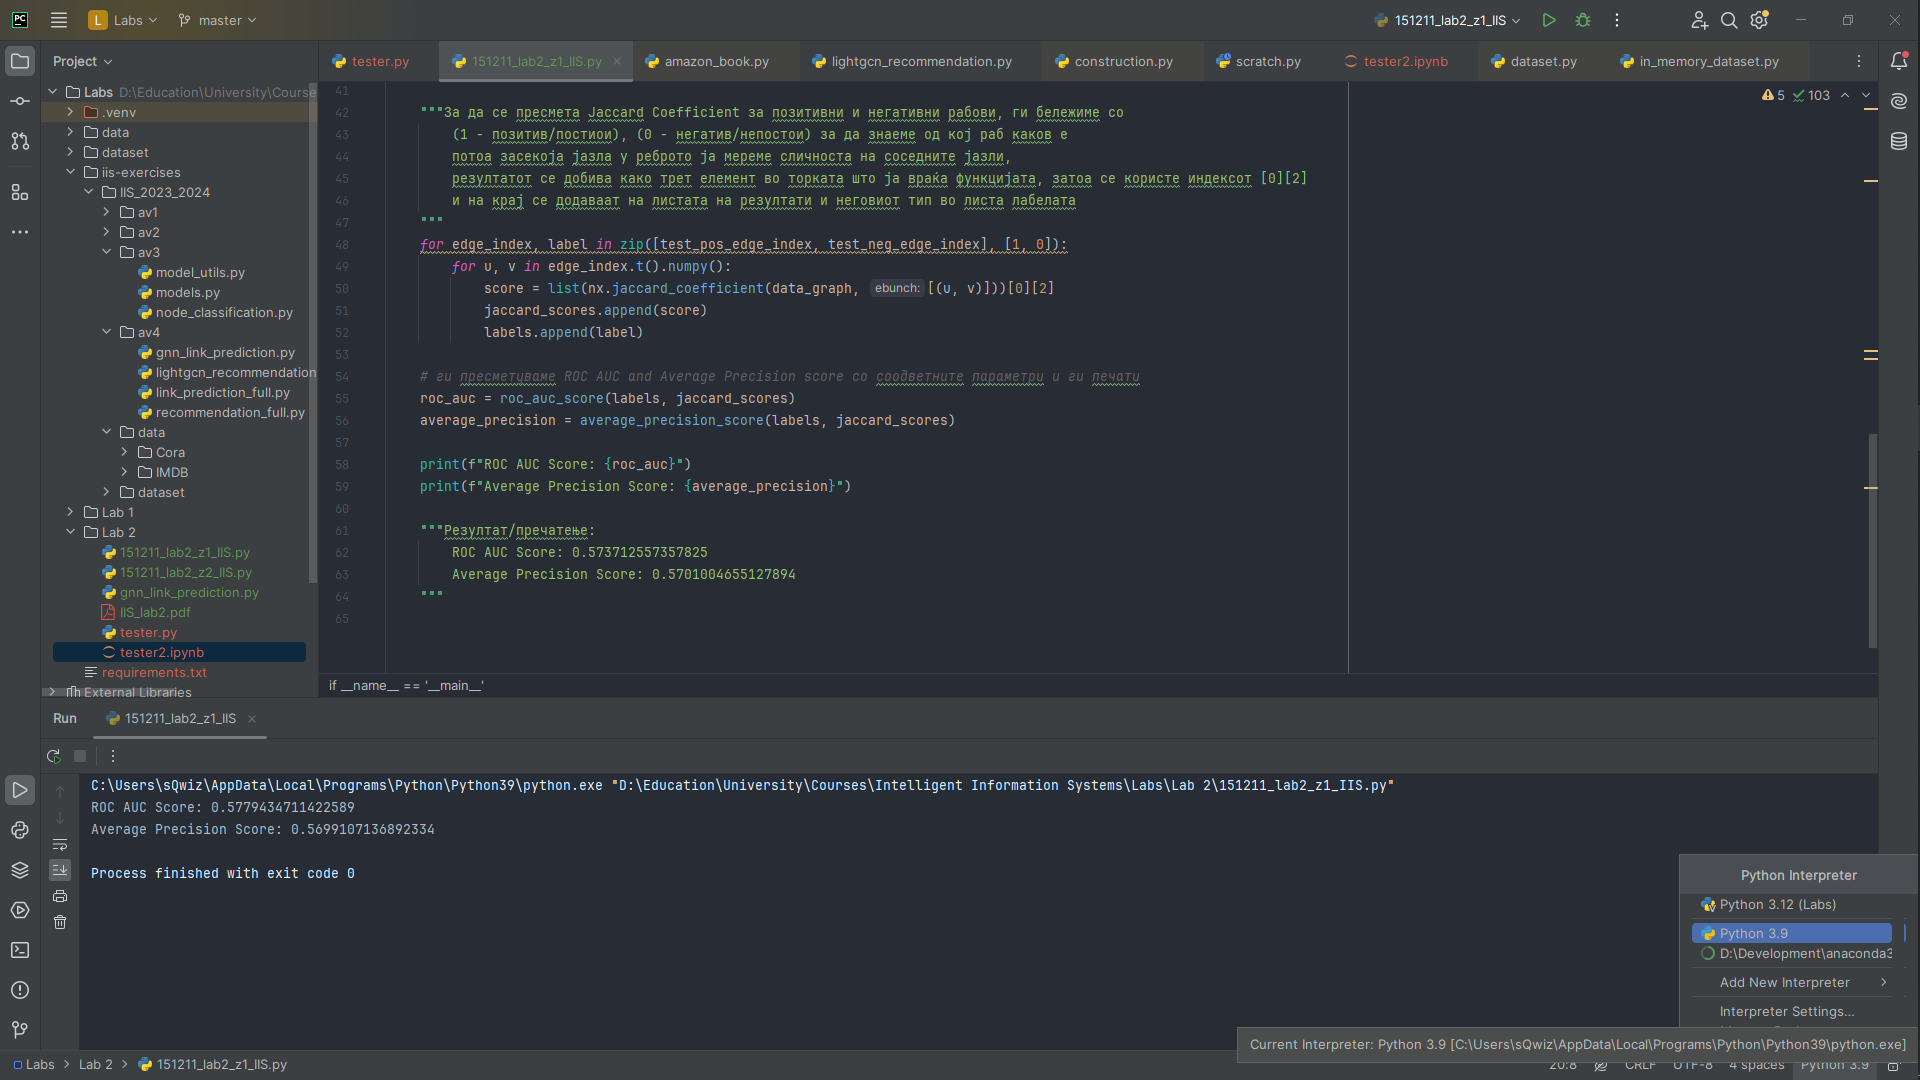

In [7]:
""" Креирање на моделот за трансформација со RandomLinkSplit,со соодветни барањата на задачата
- num_test = 20% од врските како позитивни примероци
- neg_sampling_ratio = толку врски во графот кои не постојат и ќе претставуваат негативни примероци при тестирањето
"""
transform = RandomLinkSplit(num_val=0.1,
                            num_test=0.2,
                            is_undirected=True,
                            neg_sampling_ratio=1.0,
                            split_labels=True)

data.to_homogeneous()
# Делба со примена на трансформацјата
train_data, val_data, test_data = transform(data)
"""Претварање на множеството во граф за да може да работи со networkx,
каде се користе jaccard_coefficient методот за главната пресметка. Овде највише заглаив бидејки не го разбирав податочниот модел"""
data_graph = to_networkx(train_data, to_undirected=True)
# Вадење на позитивни и негативни рабови
test_pos_edge_index = test_data.pos_edge_label_index
test_neg_edge_index = test_data.neg_edge_label_index
jaccard_scores = []
labels = []
"""За да се пресмета Jaccard Coefficient за позитивни и негативни рабови, ги бележиме со
    (1 - позитив/постиои), (0 - негатив/непостои) за да знаеме од кој раб каков е
    потоа засекоја јазла у реброто ја мереме сличноста на соседните јазли,
    резултатот се добива како трет елемент во торката што ја враќа функцијата, затоа се користе индексот [0][2]
    и на крај се додаваат на листата на резултати и неговиот тип во листа лабелата
"""
for edge_index, label in zip([test_pos_edge_index, test_neg_edge_index], [1, 0]):
    for u, v in edge_index.t().numpy():
        score = list(nx.jaccard_coefficient(data_graph, [(u, v)]))[0][2]
        jaccard_scores.append(score)
        labels.append(label)
# ги пресметуваме ROC AUC and Average Precision score со соодветните параметри и ги печати
roc_auc = roc_auc_score(labels, jaccard_scores)
average_precision = average_precision_score(labels, jaccard_scores)
print(f"ROC AUC Score: {roc_auc}")
print(f"Average Precision Score: {average_precision}")
"""Резултат/пречатење:
    ROC AUC Score: 0.573712557357825
    Average Precision Score: 0.5701004655127894
"""

ValueError: The 'RandomLinkSplit' transform expects 'edge_types' to be specified when operating on 'HeteroData' objects

## Задача 2

---



 gnn_link_prediction.py од лабораториската вежба, модифицирана за да работи со Amazonbook множеството (moive и actor заменети со book user)

In [8]:

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['book'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels, data):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


def train_link_prediction(model, train_data, val_data, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                     train_data['user', 'book'].edge_label_index)
        target = train_data['user', 'book'].edge_label
        loss = mse_loss(pred, target)
        loss.backward()
        optimizer.step()

        model.eval()
        pred = model(val_data.x_dict, val_data.edge_index_dict,
                     val_data['user', 'book'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = val_data['user', 'book'].edge_label.float()
        val_loss = mse_loss(pred, target).sqrt()

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')


In [29]:
# Вадење на бројевите на корисници и книги
num_users, num_books = data['user'].num_nodes, data['book'].num_nodes

# Бидејки во множеството недостасуваат карактеристики на јазлите. Ги додаваме векторите со единици на следниот начин:
data['user'].x = torch.ones(num_users, 1)
data['book'].x = torch.ones(num_books, 1)

""" Креирање на моделот за трансформација со RandomLinkSplit,со соодветни барањата на задачата
- num_test = Користете 20% од врските како примероци за тестирање
- num_val = 20% за валидација, а а останатите 60% за тренирање
- neg_sampling_ratio = толку врски во графот кои не постојат и ќе претставуваат негативни примероци при тестирањето
"""
train_val_test_split = RandomLinkSplit(num_val=0.2,
                                       num_test=0.2,
                                       add_negative_train_samples=True,
                                       edge_types=('user', 'rates', 'book'),
                                       rev_edge_types=('book', 'rated_by', 'user'))

# Делба со примена на трансформацјата
train_data, val_data, test_data = train_val_test_split(data)

# Креирање на модел
model = Model(hidden_channels=128, data=data)

# Дефинирање на оптимизатор
optimizer = SGD(model.parameters(), lr=0.0001)

# За некоја причина мн споро трае процесирањето epochs го смалив на 10 заради тестирањето
# train_link_prediction(model, train_data, val_data, optimizer, 100)
train_link_prediction(model, train_data, val_data, optimizer, 10)



Epoch: 000, Loss: 0.3033, Val Loss: 0.5502
Epoch: 001, Loss: 0.3027, Val Loss: 0.5496
Epoch: 002, Loss: 0.3020, Val Loss: 0.5491
Epoch: 003, Loss: 0.3014, Val Loss: 0.5485
Epoch: 004, Loss: 0.3009, Val Loss: 0.5480
Epoch: 005, Loss: 0.3003, Val Loss: 0.5475
Epoch: 006, Loss: 0.2997, Val Loss: 0.5470
Epoch: 007, Loss: 0.2991, Val Loss: 0.5464
Epoch: 008, Loss: 0.2986, Val Loss: 0.5459
Epoch: 009, Loss: 0.2980, Val Loss: 0.5454


# Задача 3

---



lightgcn_recommendation.py од лабораториската

In [30]:
def train(dataset, train_loader, model, optimizer, num_actors, num_movies, epochs=1):
    for epoch in range(epochs):
        total_loss, total_examples = 0, 0

        for node_ids in train_loader:
            pos_edge_label_index = dataset.edge_index[:, node_ids]
            neg_edge_label_index = torch.stack([pos_edge_label_index[0],
                                                torch.randint(num_actors, num_actors + num_movies,
                                                              (node_ids.numel(),))],
                                               dim=0)
            edge_label_index = torch.cat([pos_edge_label_index, neg_edge_label_index], dim=1)

            optimizer.zero_grad()

            pos_rank, neg_rank = model(dataset.edge_index, edge_label_index).chunk(2)

            loss = model.recommendation_loss(pos_rank, neg_rank, node_id=edge_label_index.unique())
            loss.backward()
            optimizer.step()

            total_loss += float(loss) * pos_rank.numel()
            total_examples += pos_rank.numel()

            print(f'Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}')


In [ ]:
# Вадење на бројевите на корисници и книги
num_users, num_books = data['user'].num_nodes, data['book'].num_nodes
# Бидејки во множеството недостасуваат карактеристики на јазлите. Ги додаваме векторите со единици на следниот начин:
# data['user'].x = torch.ones(num_users, 1)
# data['book'].x = torch.ones(num_books, 1)

# Претварање на графот во хомогена форма
data = data.to_homogeneous()

""" Креирање на моделот за трансформација со RandomLinkSplit,со соодветни барањата на задачата
- num_test = Користете 20% од врските како примероци за тестирање
- num_val = 0% за валидација, а а останатите 80% за тренирање
- neg_sampling_ratio = толку врски во графот кои не постојат и ќе претставуваат негативни примероци при тестирањето
"""
train_test_split = RandomLinkSplit(num_val=0.0,
                                       num_test=0.2,
                                       add_negative_train_samples=True,
                                       edge_types=('user', 'rates', 'book'),
                                       rev_edge_types=('book', 'rated_by', 'user'))


# Делба со примена на трансформацјата
train_data, val_data, test_data = train_test_split(data)


# Креирање на модел
model = LightGCN(data.num_nodes, embedding_dim=128, num_layers=1)

# Дефинирање на оптимизатор
optimizer = SGD(model.parameters(), lr=0.0001)

# Спремање на податоците за тренирање
data_loader = DataLoader(range(train_data.num_edges), batch_size=1024, shuffle=True)


# Тренирање на податоците
train(data, data_loader, model, optimizer, num_users, num_books, 1)



Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
Epoch: 000, Loss: 0.6931
